## Import Relevant Libraries

In [24]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import joblib

## Full Machine Learning Pipeline

We are explected to build an model that can predict possible categories for any product. We will be using product name and it's description to find relevant categories.

I have followed the CRISP-DM Process:

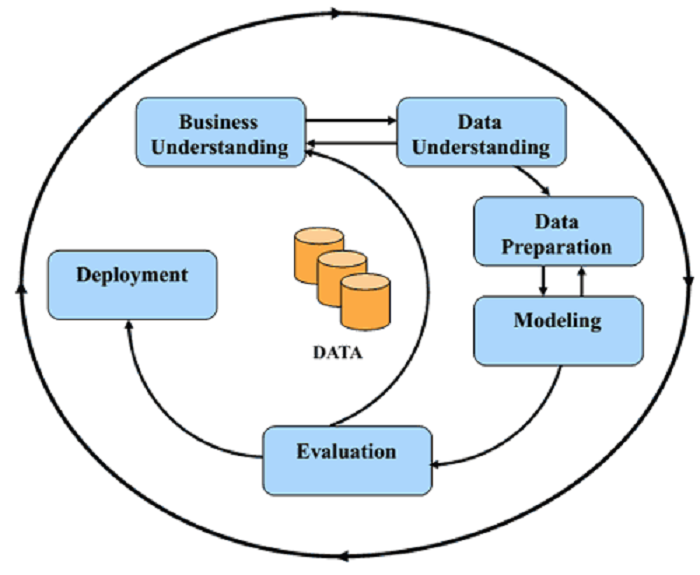

Import Dataset
The dataset can be found here: https://github.com/BestBuyAPIs/open-data-set

It contains data in the form of three json files : categories.json, products.json and stores.json.

The stores.json contains information like store id, type, name, address, hours etc which is not relevant for this task at this point. The categories.json list different categories from which our predictions will belong to, but will not be used for our work. The file used is product.json which contains the product names, description and their categories, from which our model will learn to tag categories to new products.

In [25]:
#IMPORTING JSON FILE 
with open("products.json",encoding = "utf = 8") as f:
    data = json.load(f)

In [26]:
data[10] 

{'sku': 346646,
 'name': 'Metra - Radio Dash Multikit for Select GM Vehicles - Black',
 'type': 'HardGood',
 'price': 16.99,
 'upc': '086429003273',
 'category': [{'id': 'abcat0300000', 'name': 'Car Electronics & GPS'},
  {'id': 'pcmcat165900050023', 'name': 'Car Installation Parts & Accessories'},
  {'id': 'pcmcat331600050007', 'name': 'Car Audio Installation Parts'},
  {'id': 'pcmcat165900050031', 'name': 'Deck Installation Parts'},
  {'id': 'pcmcat165900050033', 'name': 'Dash Installation Kits'}],
 'shipping': 0,
 'description': 'From our expanded online assortment; compatible with select GM vehicles; plastic material',
 'manufacturer': 'Metra',
 'model': '99-4500',
 'url': 'http://www.bestbuy.com/site/metra-radio-dash-multikit-for-select-gm-vehicles-black/346646.p?id=1210376657731&skuId=346646CC',
 'image': 'http://img.bbystatic.com/BestBuy_US/images/products/3466/346646_rc.jpg'}

From the above example we can see **product name : Metra - Radio Dash Multikit for Select GM Vehicles - Black** with **description : From our expanded online assortment; compatible with select GM vehicles; plastic material** belongs to **categories like Car Electronics & GPS, Car Installation Parts & Accessories, Car Audio Installation Parts, Deck Installation Parts and Dash Installation Kits**.

In [27]:
# creating dataframe with three rows (name,description,categories)
column_names = ['name','description','categories']
df = pd.DataFrame(columns = column_names)

In [28]:
names,descriptions,categories = [],[],[]
for product in data:
  names.append(product['name'])
  descriptions.append(product['description'])
  productCategories = []
  for cat in product['category']:
    productCategories.append(cat['name'])
  categories.append(productCategories)

In [29]:
df = pd.DataFrame(list(zip(names,descriptions,categories)) ,columns = column_names)
df

,name,description,categories
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,"[Connected Home & Housewares, Housewares, Hous..."
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,"[Connected Home & Housewares, Housewares, Hous..."
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,"[Connected Home & Housewares, Housewares, Hous..."
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,"[Connected Home & Housewares, Housewares, Hous..."
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,"[Connected Home & Housewares, Housewares, Hous..."
...,...,...,...
51641,Honeywell - True HEPA Replacement Filters for ...,Compatible with select Honeywell air purifier ...,"[Appliances, Appliance Parts & Accessories, Ai..."
51642,Dyson - Hard Floor Wipes for Dyson Hard DC56 V...,Removes dirt and grime from hard floors; cloth...,"[Appliances, Appliance Parts & Accessories, Va..."
51643,Aleratec - Drive Enclosure - Internal - Black,"1 x Total Bay - 1 x 2.5"" Bay","[Computers & Tablets, Computer Accessories & P..."
51644,Amazon - Fire TV Stick,"Streams 1080p content; dual-band, dual-antenna...","[TV & Home Theater, Streaming Media Players, R..."


There are total **51646** products listed in the product.json file.
As each instanse can belong to multiple categories, so these types of problems are known as **multi-label classification problem**, where we have a set of target labels.
If there are multiple categories but each instance is assigned only one, therefore such problems are known as **multi-class classification problem**.

Multi-class problem acknowledge that all the classes are mutually exclusive, but in our case it is not as a product can belong to multiple classes/categories.

In [30]:
cat = pd.DataFrame(df['categories'].to_list()) # listing the categories seperately
cat.head()

,0,1,2,3,4,5,6
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,None,None,None


In [31]:
# finding total unique categories/classes from which our prediction will belong too
category_0 = cat[0].unique()
category_1 = cat[1].unique()
category_2 = cat[2].unique()
category_3 = cat[3].unique()
category_4 = cat[4].unique()
category_5 = cat[5].unique()
category_6 = cat[6].unique()
cates = np.concatenate([category_0, category_1, category_2,category_3,category_4,category_5,category_6])
cates = list(dict.fromkeys(cates))
cates = [x for x in cates if x is not None] # remove None
len(cates) # number of unique classes/categories

1802

In [32]:
cat = pd.concat([cat,pd.DataFrame(columns = list(cates))]) # concatnate categories/classes to original dataframe
cat.fillna(0, inplace = True) # fill with zero
cat.head()

,0,1,2,3,4,5,6,Connected Home & Housewares,Carfi Instore Only,Car Electronics & GPS,...,Outdoor Sofas,Outdoor Benches,3D Printing Accessories,Outdoor Storage Cabinets,Outdoor Bistro Sets,Signal Cables,Outdoor Shades & Canopies,Outdoor Cushions & Pillows,Outdoor Swing Chairs,Color All-in-one Printers
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# filling attendence for all the categories/classes
for i in range(7):
  row = 0
  for category in cat[i]:
    if category!= 0:
      cat.loc[row,category] = 1 # loc is label-based, which means that you have to specify rows and columns based on their row and column labels.
    row = row + 1
# iloc is integer position-based, so you have to specify rows and columns by their integer position values (0-based integer position)

In [34]:
cat.head()

,0,1,2,3,4,5,6,Connected Home & Housewares,Carfi Instore Only,Car Electronics & GPS,...,Outdoor Sofas,Outdoor Benches,3D Printing Accessories,Outdoor Storage Cabinets,Outdoor Bistro Sets,Signal Cables,Outdoor Shades & Canopies,Outdoor Cushions & Pillows,Outdoor Swing Chairs,Color All-in-one Printers
0,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Connected Home & Housewares,Housewares,Household Batteries,Alkaline Batteries,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df2 = pd.concat([df['name'],df['description'],cat.loc[:,"2-Channel Amps":]],axis=1) # creating new dataframe which contains name of product,description and categories it belong to
df2.head()

,name,description,2-Channel Amps,Monitor & Video Cables,Coffee Pods & Beans,Blenders,Projector Screens,Laminators,Hair Dryers,Over-Ear Headphones,...,Outdoor Sofas,Outdoor Benches,3D Printing Accessories,Outdoor Storage Cabinets,Outdoor Bistro Sets,Signal Cables,Outdoor Shades & Canopies,Outdoor Cushions & Pillows,Outdoor Swing Chairs,Color All-in-one Printers
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df2.shape

(51646, 943)

There are **51646** product with **1802** classes/category.

## Data Analysis

Count of occurance of each category, to check most frequently occuring categories.

In [37]:
bar_plot = pd.DataFrame()
bar_plot['category'] = df2.columns[2:] # column name, which are categories
bar_plot['count'] = df2.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head() # Top 5 most occuring categories

,category,count
0,iPhone Cases & Clips,1892
1,Dash Installation Kits,739
2,Printer Ink,497
3,Cookware,486
4,Laptop Bags & Cases,432


In [38]:
threshold = 500 # A threshold is a value below which all those classes whose count is less than threshold will be treated as 'other' category

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 

pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()  

sns.barplot(bar_plot['category'][:60], bar_plot['count'][:60], palette=np.array(pal[::-1])[rank]) # include first few values
plt.axhline(threshold, ls='--', c='red')
plt.title("Most Common Categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
# plt.xticks(color='w') # comment this to view labels
plt.show()

TypeError: ignored

<Figure size 1500x800 with 0 Axes>

In [39]:
threshold = 100 # taking a lower threshold so can include higher number of classes/categories in consideration, can change this to even lower if want more classes

warnings.filterwarnings('ignore')

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>threshold]
categories = main_categories['category'].values
categories = np.append(categories,'Others')
not_category = []
df2['Others'] = 0

for i in df2.columns[2:]:
    if i not in categories:
        df2['Others'][df2[i] == 1] = 1
        not_category.append(i)

df2.drop(not_category, axis=1, inplace=True)

In [40]:
df2.shape

(51646, 71)

In [41]:
df2

,name,description,Coffee Pods & Beans,Blenders,Projector Screens,Over-Ear Headphones,DSLR Lenses,Laptop Chargers & Adapters,Coffee Makers,iPhone Cases & Clips,...,Multi-Cup Coffee Makers,Universal Camera Bags & Cases,Electric Tea Kettles,In-Ceiling Speakers,Full-Size Blenders,Smartwatch Bands,Outdoor Seating,iPhone 6s Plus Cases,iPhone 6s Cases,Others
0,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51641,Honeywell - True HEPA Replacement Filters for ...,Compatible with select Honeywell air purifier ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51642,Dyson - Hard Floor Wipes for Dyson Hard DC56 V...,Removes dirt and grime from hard floors; cloth...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
51643,Aleratec - Drive Enclosure - Internal - Black,"1 x Total Bay - 1 x 2.5"" Bay",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51644,Amazon - Fire TV Stick,"Streams 1080p content; dual-band, dual-antenna...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
most_common_cat = pd.DataFrame()
most_common_cat['category'] = df2.columns[2:]
most_common_cat['count'] = df2.iloc[:,2:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat.head()

,category,count
0,Others,13397
1,iPhone Cases & Clips,1892
2,Dash Installation Kits,739
3,Printer Ink,497
4,Cookware,486


In [43]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 

pal = sns.color_palette("Blues_r", len(most_common_cat))
rank = most_common_cat['count'].argsort().argsort()  

sns.barplot(most_common_cat['category'][:50], most_common_cat['count'][:50], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most common categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

TypeError: ignored

<Figure size 1500x800 with 0 Axes>

In [44]:
rowSums = df2.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

In [45]:
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Number of categories per product", fontsize=24)
plt.ylabel('Number of Products', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

plt.show()

TypeError: ignored

<Figure size 1000x600 with 0 Axes>

In [46]:
boxplot = df2.copy()
boxplot['len'] = df2.description.apply(lambda x: len(x)) # length of descriptions

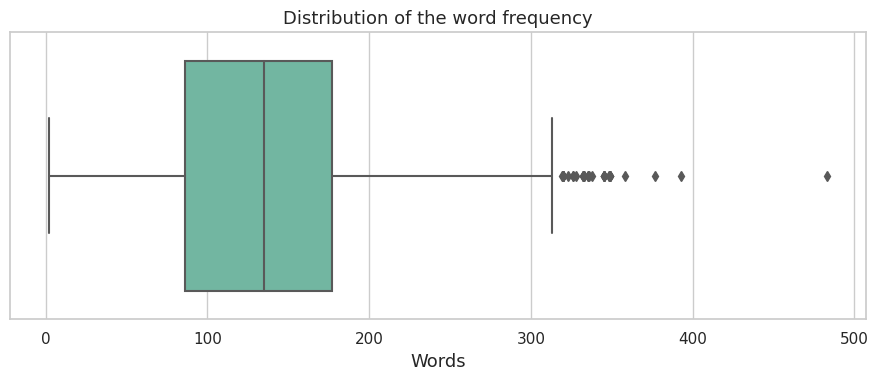

In [47]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})
plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Words')
plt.title("Distribution of the word frequency", fontsize=13)
plt.tight_layout(h_pad=3)

We can observe that most description's length range from 100 too 200 but there are few outliers till 480.

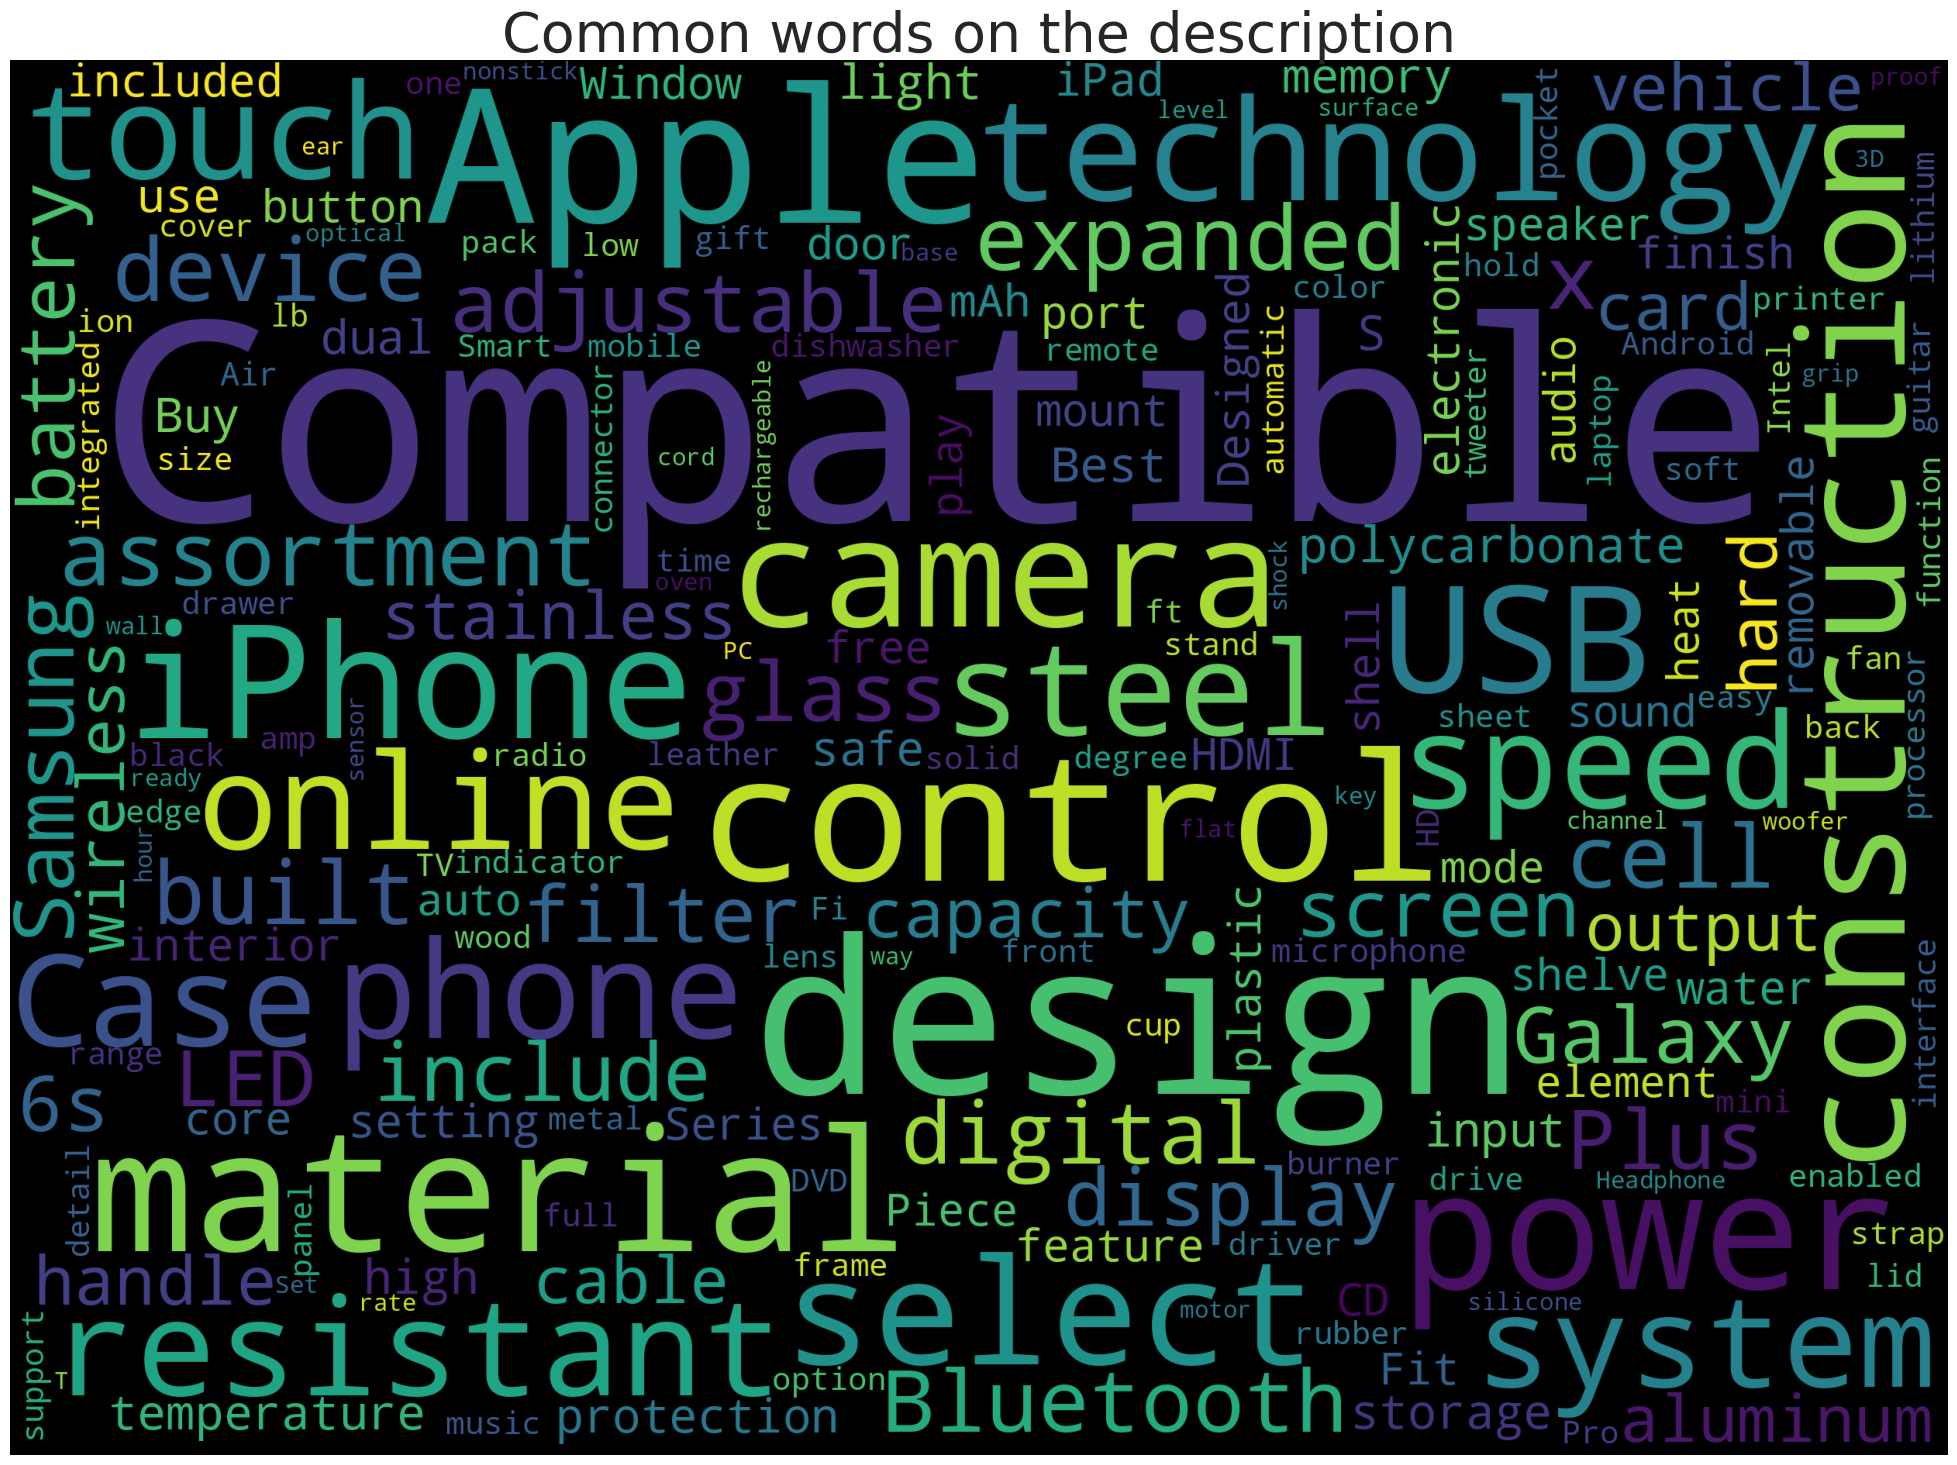

In [48]:
# Visualizing the main context/keywords of the description of products, to better understand the nature of data
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(25,25))
text = df2.description.values
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  collocations=False,
                  width=2500,
                  height=1800
                  ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words on the description",fontsize=40)
plt.imshow(cloud)

In [49]:
# Utility function for data cleaning, natural language processing concepts

def decontract(sentence):
    sentence = str(sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence): 
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    sentence = str(sentence)
    global re_stop_words
    return re_stop_words.sub("", sentence)

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

stemmer = SnowballStemmer("english")
def stemming(sentence):
    sentence = str(sentence)
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [50]:
# Applying data cleaning on description to ignore irrelevant words
df2['description'] = df2['description'].str.lower()
df2['description'] = df2['description'].apply(decontract)
df2['description'] = df2['description'].apply(cleanPunc)
df2['description'] = df2['description'].apply(keepAlpha)
df2['description'] = df2['description'].apply(removeStopWords)
df2['description'] = df2['description'].apply(stemming)

In [51]:
df2.head()

,name,description,Coffee Pods & Beans,Blenders,Projector Screens,Over-Ear Headphones,DSLR Lenses,Laptop Chargers & Adapters,Coffee Makers,iPhone Cases & Clips,...,Multi-Cup Coffee Makers,Universal Camera Bags & Cases,Electric Tea Kettles,In-Ceiling Speakers,Full-Size Blenders,Smartwatch Bands,Outdoor Seating,iPhone 6s Plus Cases,iPhone 6s Cases,Others
0,Duracell - AAA Batteries (4-Pack),compat select electron devic aaa size duralock...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Duracell - AA 1.5V CopperTop Batteries (4-Pack),longlast energi duralock power preserv technol...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Duracell - AA Batteries (8-Pack),compat select electron devic aa size duralock ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Energizer - MAX Batteries AA (4-Pack),pack aa alkalin batteri batteri tester includ,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Duracell - C Batteries (4-Pack),compat select electron devic c size duralock p...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Applying data cleaning on product name to ignore irrelevant words
df2['name'] = df2['name'].str.lower()
df2['name'] = df2['name'].apply(decontract)
df2['name'] = df2['name'].apply(cleanPunc)
df2['name'] = df2['name'].apply(keepAlpha)
df2['name'] = df2['name'].apply(removeStopWords)
df2['name'] = df2['name'].apply(stemming)

In [53]:
# creating new column information which is concatenation of product name and description, which stores overall context about any product
df2["information"] = df2["name"] + df2["description"]
df2.head()

,name,description,Coffee Pods & Beans,Blenders,Projector Screens,Over-Ear Headphones,DSLR Lenses,Laptop Chargers & Adapters,Coffee Makers,iPhone Cases & Clips,...,Universal Camera Bags & Cases,Electric Tea Kettles,In-Ceiling Speakers,Full-Size Blenders,Smartwatch Bands,Outdoor Seating,iPhone 6s Plus Cases,iPhone 6s Cases,Others,information
0,duracel aaa batteri pack,compat select electron devic aaa size duralock...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,duracel aaa batteri packcompat select electron...
1,duracel aa v coppertop batteri pack,longlast energi duralock power preserv technol...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,duracel aa v coppertop batteri packlonglast en...
2,duracel aa batteri pack,compat select electron devic aa size duralock ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,duracel aa batteri packcompat select electron ...
3,energ max batteri aa pack,pack aa alkalin batteri batteri tester includ,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,energ max batteri aa packpack aa alkalin batte...
4,duracel c batteri pack,compat select electron devic c size duralock p...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,duracel c batteri packcompat select electron d...


## Model Creation

Splitting the data into train/test set

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df2['information'], 
                                                    df2[df2.columns[2:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True)

In [55]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2') # Using a tf-idf weighting scheme rather than normal boolean weights for better performance
vectorizer.fit(X_train) # Reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [56]:
print("X_train shape : ",X_train.shape)
print("X_test shape : ",X_test.shape)

X_train shape :  (36152, 535768)
X_test shape :  (15494, 535768)


To solve multi-label problems, we mainly have approaches:


1.   **Binary classification** :  This strategy divides the problem into several independent binary classification tasks. It resembles the one-vs-rest method, but each classifier deals with a single label, which means the algorithm assumes they are mutually exclusive.
2.  **Multi-class classification** : The labels are combined into one big binary classifier called powerset. For instance, having the targets A, B, and C, with 0 or 1 as outputs, we have A B C -> [0 1 0], while the binary classification transformation treats it as A B C -> [0] [1] [0].

We will first use the Binary classification technique.


In [57]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))]) 
# one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

# sag : Algorithm to use in the optimization problem, ‘saga’ also supports ‘elasticnet’ penalty  Reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# n_jobs : The number of jobs to use for the computation: the n_classes one-vs-rest problems are computed in parallel. Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
# clf : name given to the Pipeline

accuracy = 0
auc = 0
modelNumber = 1
for category in df2.columns[2:-1]:    
    LR_pipeline.fit(X_train, y_train[category]) # Training logistic regression model on train data
    prediction = LR_pipeline.predict(X_test)    # calculating predictions
    acc = accuracy_score(y_test[category], prediction)
    au = roc_auc_score(y_test[category],prediction)
    accuracy = accuracy + acc
    auc = auc + au
    print('CATEGORY => {} '.format(category),'AUC ROC score => {}'.format(au)," Accuracy => {}".format(acc))
    filename = str(modelNumber)+"_model.sav"
    joblib.dump(LR_pipeline, filename)          # saving individual classifiers for later use
    modelNumber += 1
print("-------------------------------------------------------------------------------------------------------------------------------")
print('Test averaged Accuracy => {}'.format(accuracy/len(df2.columns[2:-1])))
print('Test averaged AUC ROC Score => {}'.format(auc/len(df2.columns[2:-1])))

CATEGORY => Coffee Pods & Beans  AUC ROC score => 0.7111111111111111  Accuracy => 0.9983219310700916
CATEGORY => Blenders  AUC ROC score => 0.7650602409638554  Accuracy => 0.9974828966051374
CATEGORY => Projector Screens  AUC ROC score => 0.7083333333333334  Accuracy => 0.9986446366335355
CATEGORY => Over-Ear Headphones  AUC ROC score => 0.5848408977324521  Accuracy => 0.997031108816316
CATEGORY => DSLR Lenses  AUC ROC score => 0.8231058472017371  Accuracy => 0.9979992255066478
CATEGORY => Laptop Chargers & Adapters  AUC ROC score => 0.5476190476190477  Accuracy => 0.9975474377178263
CATEGORY => Coffee Makers  AUC ROC score => 0.6642532972732661  Accuracy => 0.9969020265909384
CATEGORY => iPhone Cases & Clips  AUC ROC score => 0.9780898337595908  Accuracy => 0.9936104298438105
CATEGORY => Portable Chargers/Power Packs  AUC ROC score => 0.7654301695025328  Accuracy => 0.9967084032528721
CATEGORY => Printer Ink  AUC ROC score => 0.9570738907299536  Accuracy => 0.9988382599716019
CATEGORY

In [58]:
# Api for category prediction
def categoryPrediction(name,description):
  # performing necessary data cleaning operations od product name and description
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description  # creating information text
  X_api = vectorizer.transform([information]) # transforming using already trained vectorizing transformer

  # LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
  accuracy = 0
  modelNumber = 1
  for category in df2.columns[2:-1]:
    # LR_pipeline.fit(X_train, y_train[category])
    filename = str(modelNumber)+"_model.sav"
    modelNumber += 1
    LR_pipeline = joblib.load(filename) # loading already saved model

    # calculating test accuracy
    prediction = LR_pipeline.predict(X_api)
    if prediction==1:
      print('CATEGORY {}'.format(category)) # if models predicts true print that category

In [59]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
categoryPrediction(name,description)

In [60]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
categoryPrediction(name,description)

In [61]:
# Test for API
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
categoryPrediction(name,description)

CATEGORY Others


Other models worth trying are Naive Bayes, SVC, Random Forest.

# Deep Learning Based Models

Follows the Multi-class classification based model.

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [64]:
df2['information']

0        duracel aaa batteri packcompat select electron...
1        duracel aa v coppertop batteri packlonglast en...
2        duracel aa batteri packcompat select electron ...
3        energ max batteri aa packpack aa alkalin batte...
4        duracel c batteri packcompat select electron d...
                               ...                        
51641    honeywel true hepa replac filter select honeyw...
51642    dyson hard floor wipe dyson hard dc vacuum pac...
51643    aleratec drive enclosur intern blackx total ba...
51644    amazon fire tv stickstream p content dualband ...
51645    proctor silex slice toaster oven whiteproctor ...
Name: information, Length: 51646, dtype: object

In [65]:
tokenizer = Tokenizer(num_words=5000, lower=True) # lower : boolean. Whether to convert the texts to lowercase. , num_words : the maximum number of words to keep, based on word frequency.
tokenizer.fit_on_texts(df2['information']) # encoding words of information to integers, Updates internal vocabulary based on a list of sequences.
sequences = tokenizer.texts_to_sequences(df2['information'])
x = pad_sequences(sequences, maxlen=500) # provide tagging to make each sequence of length 500

In [66]:
x.shape

(51646, 500)

In [67]:
# Splitting dataset in train/test set
X_train, X_test, y_train, y_test = train_test_split(x, df2[df2.columns[2:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0)

In [68]:
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}    
most_common_cat.head()

,category,count,class_weight
0,Others,13397,0.005150
1,iPhone Cases & Clips,1892,0.036469
2,Dash Installation Kits,739,0.093369
3,Printer Ink,497,0.138833
4,Cookware,486,0.141975


In [69]:
categories # categories in which our results will belong to

array(['iPhone Cases & Clips', 'Dash Installation Kits', 'Printer Ink',
       'Cookware', 'Laptop Bags & Cases', 'All TV Stands',
       'Patio Furniture & Decor', 'Food Preparation Utensils',
       'Portable Chargers/Power Packs', 'PC Laptops', 'Toner',
       'Electric Ranges', 'Gas Ranges', 'DSLR Lenses',
       'Smartwatch Accessories', 'Cases', 'Laptop Batteries',
       'Camera Bags & Cases', 'All Printers', 'Blenders',
       '3D Printer Filament', 'Coffee Makers', 'Internal Batteries',
       'Smartwatch Bands', 'Camera Batteries', 'iPhone 6s Cases',
       'Wall Mount Range Hoods', 'In-Wall & In-Ceiling Speakers',
       'Over-Ear Headphones', 'Bakeware', 'On-Ear Headphones',
       'Deck Harnesses', 'Universal Camera Bags & Cases', 'Grills',
       'Outdoor Speakers', 'Luggage', 'Tea Kettles',
       'Flashes & Accessories', 'Multi-Cup Coffee Makers', 'Mice',
       'Electric Dryers', 'Apple Watch Bands & Straps',
       'iPhone 6s Plus Cases', 'Security Camera Systems',
  

In [70]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 500

In [71]:
num_classes # number of categories/classes

69

In [72]:
max_words # max words/ total vocab + 1 

37031

In [75]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen)) # Turns positive integers (indexes) into dense vectors of fixed size, input_dim = 500, output_dim = 300
#model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(), # Reduce learning rate when a metric has stopped improving
    #EarlyStopping(patience=10),
    ModelCheckpoint(filepath='model-neural-net.h5', save_best_only=True)
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          11109300  
                                                                 
 dense_2 (Dense)             (None, 500, 300)          90300     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 69)                20769     
                                                                 
Total params: 11,220,369
Trainable params: 11,220,369
Non-trainable params: 0
_________________________________________________________________


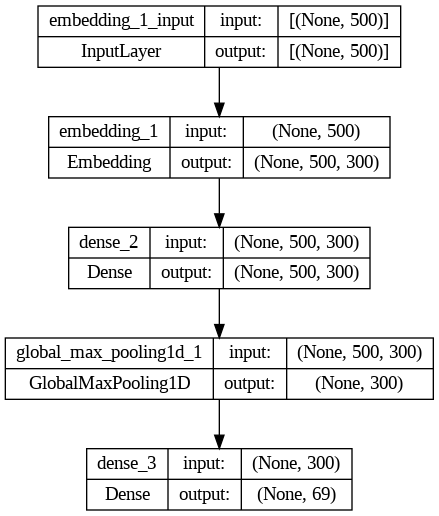

In [76]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_nn_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
791/791 [==============================] - 50s 56ms/step - loss: 0.0491 - auc_1: 0.8971 - val_loss: 0.0695 - val_auc_1: 0.9183 - lr: 0.0150
Epoch 2/30
791/791 [==============================] - 12s 15ms/step - loss: 0.0552 - auc_1: 0.9188 - val_loss: 0.0492 - val_auc_1: 0.9423 - lr: 0.0150
Epoch 3/30
791/791 [==============================] - 12s 16ms/step - loss: 0.0323 - auc_1: 0.9464 - val_loss: 0.0378 - val_auc_1: 0.9532 - lr: 0.0150
Epoch 4/30
791/791 [==============================] - 12s 15ms/step - loss: 0.0277 - auc_1: 0.9526 - val_loss: 0.0369 - val_auc_1: 0.9464 - lr: 0.0150
Epoch 5/30
791/791 [==============================] - 9s 12ms/step - loss: 0.0228 - auc_1: 0.9596 - val_loss: 0.0356 - val_auc_1: 0.9332 - lr: 0.0150
Epoch 6/30
791/791 [==============================] - 9s 11ms/step - loss: 0.0256 - auc_1: 0.9559 - val_loss: 0.0520 - val_auc_1: 0.9313 - lr: 0.0150
Epoch 7/30
791/791 [==============================] - 9s 12ms/step - loss: 0.0380 - auc_1: 0.938

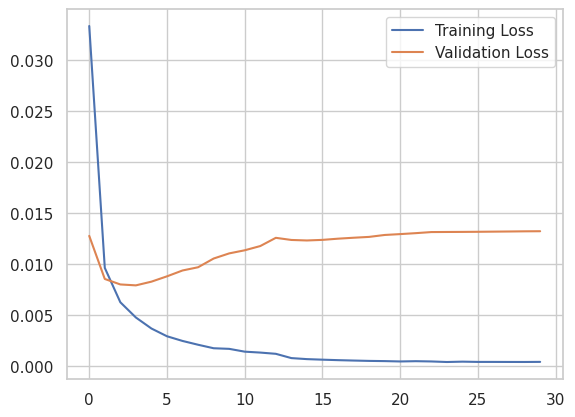

KeyError: ignored

In [93]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_1"], label="Training AUC")
plt.plot(history.history["val_auc_1"], label="Validation AUC")
plt.legend()
plt.show()

In [80]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

485/485 [==============================] - 2s 5ms/step - loss: 0.0585 - auc_1: 0.9632
auc_1: 0.9632080793380737


In [81]:
classes = [col for col in df2.columns]
classes = classes[2:-1]
classes

['Coffee Pods & Beans',
 'Blenders',
 'Projector Screens',
 'Over-Ear Headphones',
 'DSLR Lenses',
 'Laptop Chargers & Adapters',
 'Coffee Makers',
 'iPhone Cases & Clips',
 'Portable Chargers/Power Packs',
 'Printer Ink',
 'Electric Dryers',
 'Gas Dryers',
 'Camera Batteries',
 '3D Printer Filament',
 'Food Preparation Utensils',
 'Grills',
 'Cookware',
 'All TV Stands',
 'Mice',
 'Computer Keyboards',
 'All Printers',
 'Pedals',
 'Gas Ranges',
 'Toner',
 'Systems',
 'Wall Chargers & Power Adapters',
 'Electric Ranges',
 'Camera Bags & Cases',
 'Sound Bars',
 'All Point & Shoot Cameras',
 'Tea Kettles',
 'Wall Mount Range Hoods',
 'Laptop Batteries',
 'Mirrorless Lenses',
 'Internal Batteries',
 'Cases',
 'Outdoor Speakers',
 'In-Wall & In-Ceiling Speakers',
 'Bookshelf Speakers',
 'Car Chargers',
 'USB Cables & Hubs',
 'Security Camera Systems',
 'Laptop Bags & Cases',
 'On-Ear Headphones',
 'Flashes & Accessories',
 'Bakeware',
 'External Hard Drives',
 'Single Ovens',
 'PC Laptops'

In [82]:
import operator
# Utility function to get predictions using Neural Net model
def categoryPredictionNN(name,description):
  # Data cleaning process
  name = name.lower()
  name = decontract(name)
  name = cleanPunc(name)
  name = keepAlpha(name)
  name = removeStopWords(name)
  name = stemming(name)

  description = description.lower()
  description = decontract(description)
  description = cleanPunc(description)
  description = keepAlpha(description)
  description = removeStopWords(description)
  description = stemming(description)

  information = name + description
  # necessary data preprocessing steps
  sequences = tokenizer.texts_to_sequences([information])
  x = pad_sequences(sequences, maxlen=500)
  prediction = model.predict(x)
  predScores = [score for pred in prediction for score in pred]
  predDict = {}
  for cla,score in zip(classes,predScores):
    predDict[cla] = score

  return sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:10] # return top 10 results

In [83]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 99ms/step


[('Others', 1.0),
 ('Coffee Pods & Beans', 0.0),
 ('Blenders', 0.0),
 ('Projector Screens', 0.0),
 ('Over-Ear Headphones', 0.0),
 ('DSLR Lenses', 0.0),
 ('Laptop Chargers & Adapters', 0.0),
 ('Coffee Makers', 0.0),
 ('iPhone Cases & Clips', 0.0),
 ('Portable Chargers/Power Packs', 0.0)]

In [84]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 21ms/step


[('Coffee Pods & Beans', 0.0),
 ('Blenders', 0.0),
 ('Projector Screens', 0.0),
 ('Over-Ear Headphones', 0.0),
 ('DSLR Lenses', 0.0),
 ('Laptop Chargers & Adapters', 0.0),
 ('Coffee Makers', 0.0),
 ('iPhone Cases & Clips', 0.0),
 ('Portable Chargers/Power Packs', 0.0),
 ('Printer Ink', 0.0)]

In [85]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 18ms/step


[('Others', 1.7071438e-09),
 ('Systems', 1.1035541e-33),
 ('Coffee Pods & Beans', 0.0),
 ('Blenders', 0.0),
 ('Projector Screens', 0.0),
 ('Over-Ear Headphones', 0.0),
 ('DSLR Lenses', 0.0),
 ('Laptop Chargers & Adapters', 0.0),
 ('Coffee Makers', 0.0),
 ('iPhone Cases & Clips', 0.0)]

In [86]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 30ms/step


[('Others', 0.28562915),
 ('Food Preparation Utensils', 0.05345437),
 ('Wall Mount Range Hoods', 0.047984127),
 ('Coffee Makers', 0.047568265),
 ('Cookware', 0.042784877),
 ('Blenders', 0.032820683),
 ('Multi-Cup Coffee Makers', 0.02661985),
 ('Mice', 0.023263857),
 ('Portable Chargers/Power Packs', 0.021603992),
 ('Computer Keyboards', 0.02068516)]

In [87]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 30ms/step


[('Coffee Pods & Beans', 0.0),
 ('Blenders', 0.0),
 ('Projector Screens', 0.0),
 ('Over-Ear Headphones', 0.0),
 ('DSLR Lenses', 0.0),
 ('Laptop Chargers & Adapters', 0.0),
 ('Coffee Makers', 0.0),
 ('iPhone Cases & Clips', 0.0),
 ('Portable Chargers/Power Packs', 0.0),
 ('Printer Ink', 0.0)]

## Conv Net Model

In [88]:
from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D()) # This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 300)          11109300  
                                                                 
 dropout (Dropout)           (None, 500, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 498, 300)          270300    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 69)                20769     
                                                      

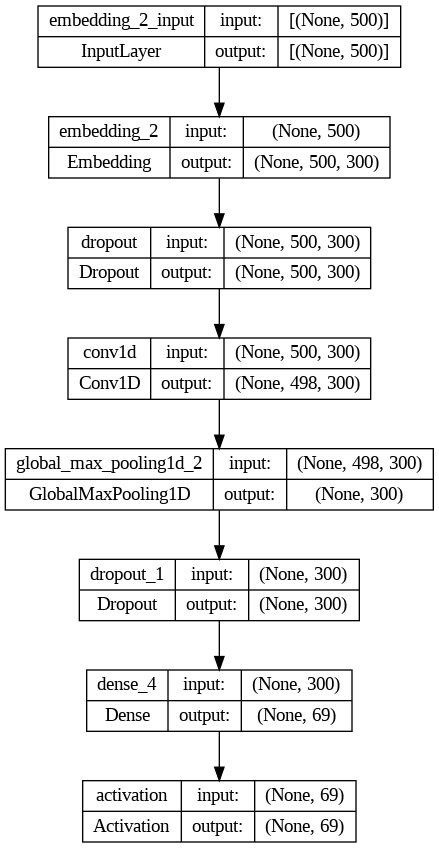

In [89]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [90]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
791/791 [==============================] - 40s 43ms/step - loss: 0.0333 - auc_2: 0.8972 - val_loss: 0.0128 - val_auc_2: 0.9888 - lr: 0.0010
Epoch 2/30
791/791 [==============================] - 18s 23ms/step - loss: 0.0096 - auc_2: 0.9911 - val_loss: 0.0086 - val_auc_2: 0.9925 - lr: 0.0010
Epoch 3/30
791/791 [==============================] - 17s 21ms/step - loss: 0.0063 - auc_2: 0.9956 - val_loss: 0.0080 - val_auc_2: 0.9912 - lr: 0.0010
Epoch 4/30
791/791 [==============================] - 17s 22ms/step - loss: 0.0048 - auc_2: 0.9976 - val_loss: 0.0079 - val_auc_2: 0.9892 - lr: 0.0010
Epoch 5/30
791/791 [==============================] - 16s 20ms/step - loss: 0.0037 - auc_2: 0.9984 - val_loss: 0.0083 - val_auc_2: 0.9866 - lr: 0.0010
Epoch 6/30
791/791 [==============================] - 14s 18ms/step - loss: 0.0029 - auc_2: 0.9988 - val_loss: 0.0088 - val_auc_2: 0.9834 - lr: 0.0010
Epoch 7/30
791/791 [==============================] - 16s 20ms/step - loss: 0.0025 - auc_2: 0.

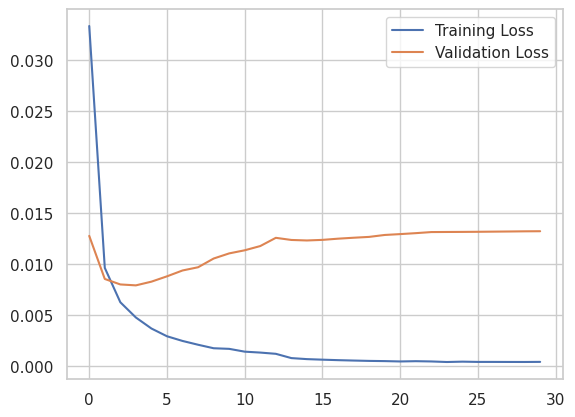

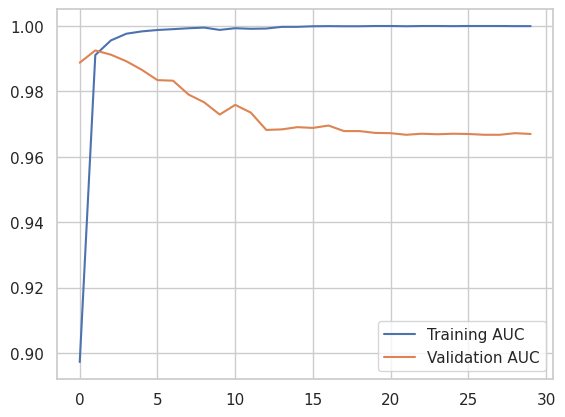

In [92]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_2"], label="Training AUC")
plt.plot(history.history["val_auc_2"], label="Validation AUC")
plt.legend()
plt.show()

In [94]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

485/485 [==============================] - 3s 5ms/step - loss: 0.0131 - auc_2: 0.9673
auc_2: 0.9672983884811401


In [95]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 129ms/step


[('Others', 0.99999857),
 ('Blenders', 5.6952103e-07),
 ('Smartwatch Accessories', 4.601469e-07),
 ('On-Ear Headphones', 1.2833094e-07),
 ('Pedals', 4.586533e-08),
 ('All Point & Shoot Cameras', 4.1382247e-08),
 ('Flashes & Accessories', 3.821724e-08),
 ('DSLR Lenses', 2.4416574e-08),
 ('Camera Bags & Cases', 2.316897e-08),
 ('iPhone Cases & Clips', 1.9718495e-08)]

In [96]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 19ms/step


[('Others', 2.61427e-08),
 ('All Point & Shoot Cameras', 5.771666e-10),
 ('iPhone Cases & Clips', 3.538541e-10),
 ('Systems', 2.8084038e-10),
 ('Cases', 2.4352179e-10),
 ('PC Laptops', 2.34629e-10),
 ('Laptop Bags & Cases', 1.4111606e-10),
 ('Security Camera Systems', 1.0977455e-10),
 ('Apple Watch Bands & Straps', 9.9636424e-11),
 ('On-Ear Headphones', 8.173841e-11)]

In [97]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 20ms/step


[('Others', 1.4804154e-06),
 ('iPhone Cases & Clips', 9.87018e-08),
 ('All TV Stands', 6.197819e-08),
 ('On-Ear Headphones', 4.6178176e-08),
 ('Internal Batteries', 2.3257343e-08),
 ('Security Camera Systems', 8.906591e-09),
 ('Car Chargers', 5.8791207e-09),
 ('Wall Chargers & Power Adapters', 2.702837e-09),
 ('Sound Bars', 2.4815168e-09),
 ('Over-Ear Headphones', 2.1389643e-09)]

In [98]:
name = "Keurig - Green Mountain Coffee Organic Ethiopia Yirgacheffe K-Cups (16-Pack)"
description = "Compatible with Keurig single-serve K-Cup and 2.0 coffee brewers; notes of citrus and ginger; 16-pack"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 17ms/step


[('Coffee Pods & Beans', 0.95861477),
 ('Coffee Pods', 0.95218587),
 ('Others', 0.54070926),
 ('Coffee Makers', 1.11868685e-05),
 ('Security Camera Systems', 2.3418778e-07),
 ('In-Wall & In-Ceiling Speakers', 1.356742e-07),
 ('On-Ear Headphones', 9.635783e-08),
 ('Car Chargers', 7.5004344e-08),
 ('iPhone 6s Cases', 2.5813204e-08),
 ('Antennas & Adapters', 1.9226443e-08)]

In [99]:
name = "Kung Fu Panda: Showdown of Legendary Legends - Xbox One"
description = "Jump into an all-out brawl for honor, glory and legend status"
prediction = categoryPredictionNN(name,description)
prediction

1/1 [==============================] - 0s 19ms/step


[('iPhone Cases & Clips', 3.243277e-07),
 ('On-Ear Headphones', 2.8615096e-08),
 ('Dash Installation Kits', 8.8208445e-09),
 ('Others', 6.087952e-09),
 ('Security Camera Systems', 5.079529e-09),
 ('Systems', 3.723237e-09),
 ('Bookshelf Speakers', 2.1278597e-09),
 ('Wall Chargers & Power Adapters', 1.7352019e-09),
 ('All Point & Shoot Cameras', 1.6705491e-09),
 ('All TV Stands', 5.369779e-10)]